# PRL-Rui Chao: QEC With Two Extra Qubit

In this notebook, I am going to implement a new error correction code purposed by Rui Chao and Ben Reichardt (see here: [Quantum Error Correction with Only Two Extra Qubits](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.121.050502)). They consider the CNOT gate error during the error detection in general quantum error correction code, and use an extra ancilla qubit as a flag to trace the CNOT gate error. In this notebook, I will implement his modified code for $[[5, 1, 3]]$ perfect code.

## I. Introduction of Background Knowledge
The perfect code is the smallest quantum error correction code for 1 logical qubit (please see appendix for details). To measure the eigenvalue of stabilizer of perfect code, we need to use the CNOT gate and Hadmard gate and assume that those gates would not bring extra error. 

In [2]:
# Follow the perfect code circuit
# Import require package
import numpy as np
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, transpile, Aer, IBMQ
from qiskit.visualization import plot_histogram
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

In [3]:
# Follow the perfect code circuit
# Construct quantum circuit
qreg_q = QuantumRegister(5, 'q')
qreg_a = QuantumRegister(4, 'a')
creg_c = ClassicalRegister(9, 'c')
circuit = QuantumCircuit(qreg_q, qreg_a, creg_c)

# Encoding...Still working on it

However, sometimes the CNOT gate can be a fault gate and introduce extra error to the circuit. During the error syndrome measurement part, we need to measure stabilizer
\begin{equation}
\mathcal{S} = \{XZZXI, IXZZX, XIXZZ, ZXIXZ\}.
\end{equation}
Note that when the CNOT gate works well and would not bring any noise, the error detecting code would not break the coherence of $|\psi_L\rangle$ while detecting the error, since the stabilizer $\mathcal{S}_i E_{a}|\psi_L\rangle=\pm |\psi_L\rangle $ and all operations in the detection circuit is $\mathcal{S}_i$ operation on the circuit. If the second or third CNOT gate has something wrong, and for example, has a $XZ$ fault. The stabilizer part becomes $XZZXI \rightarrow IXZXI$ and $(IXZXI)E_{a}|\psi_L\rangle$ would not be $\pm |\psi\rangle$. That is, after performing stabilizer operation, the quantum state, which was supposed to be unchanged, becomes $(IXZXI)E_{a}|\psi_L\rangle$ and has an extra $IXZXI$ error. Thus, we need to correct the extra error after recover all other noise. Meanwhile, the CNOT gate would also raise a $Z$ error in the ancilla qubit when it raises a $I,X,Y,Z$ fault in the main qubits. Here is a table from their paper to illustrate what kind of error the failure of CNOT will raise in the main 5 qubits. 

|  Failure  |   Original Stabilizer   |  Data Error  |
|  :----:   |         :----:          |    :----:    |
|    $IZ$   |        $XZZXI$          |    $IIZXI$   |
|    $XZ$   |        $XZZXI$          |    $IXZXI$   |
|    $YZ$   |        $XZZXI$          |    $IYZXI$   |
|    $ZZ$   |        $XZZXI$          |    $IZZXI$   |

In practice, Rui and Reichardt purpose to use an extra ancilla qubit to detect the CNOT error (shown below)

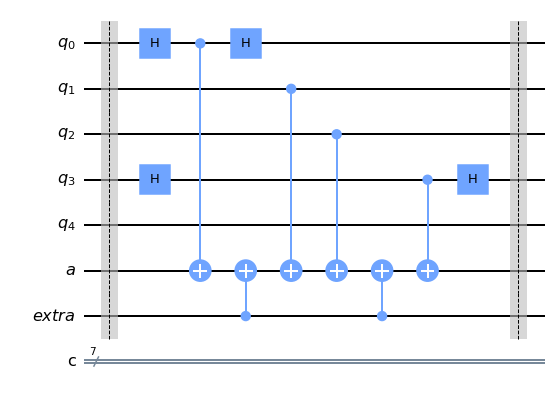

In [5]:
# Construct quantum circuit
qreg_q = QuantumRegister(5, 'q')
qreg_a = QuantumRegister(1, 'a')
qreg_aa= QuantumRegister(1, 'extra')
creg_c = ClassicalRegister(7, 'c')
circuit = QuantumCircuit(qreg_q, qreg_a, qreg_aa, creg_c)

# Error Detection Circuit
circuit.barrier()

# Correspond to stabilizer XZZXI
circuit.h(qreg_q[0])
circuit.h(qreg_aa[0])
circuit.cx(qreg_q[0], qreg_a[0])
circuit.h(qreg_q[0])
circuit.cx(qreg_aa[0], qreg_a[0])
circuit.cx(qreg_q[1], qreg_a[0])
circuit.cx(qreg_q[2], qreg_a[0])
circuit.cx(qreg_aa[0], qreg_a[0])
circuit.h(qreg_q[3])
circuit.cx(qreg_q[3], qreg_a[0])
circuit.h(qreg_q[3])
circuit.barrier()
circuit.draw()

According to the circuit, if the first CNOT gate is a fault gate, then it would raise a $Z$ error in the ancllia qubit. Note that if the target qubit has a $Z$ error, the $Z$ error would propagate into the control qubit and change the $|+\rangle$ state into $|-\rangle$ state. Then if we measure the extra ancilla qubit, we could in principle know whether the CNOT gate is a fault gate. Here we assume only one of two CNOT gate will bring an extra error, so we could prepare an extra recovery if we detect $|-\rangle$ in the extra ancilla qubit. 

## Appendix The Perfect Code

The perfect code is used to protect information of 1 qubit, and its encoding rules are complicated. We need to make a logical qubit as

\begin{align}
|0_L\rangle &= \frac{1}{4}(|00000\rangle + |10010\rangle + |01001\rangle + |10100\rangle \\
&+|01010\rangle - |11011\rangle - |00110\rangle - |11000\rangle \\
&-|11101\rangle - |00011\rangle - |11110\rangle - |01111\rangle \\
&-|10001\rangle - |01100\rangle - |10111\rangle + |00101\rangle )\\
\end{align}


\begin{align}
|1_L\rangle &= \frac{1}{4}(|11111\rangle + |01101\rangle + |10110\rangle + |01011\rangle \\
&+|10101\rangle - |00100\rangle - |11001\rangle - |00111\rangle \\
&-|00010\rangle - |11100\rangle - |00001\rangle - |10000\rangle \\
&-|01110\rangle - |10011\rangle - |01000\rangle + |11010\rangle )\\
\end{align}

Perfect code will perform correction with following procedure:
* Encode $|\psi\rangle$ , $|\psi_L\rangle=a|0_L\rangle+b|1_L\rangle$
* (Noise happen)
* Specify the noise with the help of syndrome from stabilizer. 
* Recover the noise with syndrome measurement result
* Decode $|\psi_L\rangle$ and re-generate $|\psi\rangle = a|0\rangle + b|1\rangle$